<a href="https://colab.research.google.com/drive/1IxiJ0fjBvuVslq86bR-WogzvKGoVYlJz">Abre este Jupyter en Google Colab</a>

# Caso Práctico: _Support Vector Machine (SVM)_

## Conjunto de datos: Detección de URLs maliciosas

### Descripción
The Web has long become a major platform for online criminal activities. URLs are used as the main vehicle in this domain. To counter this issues security community focused its efforts on developing techniques for mostly blacklisting of malicious URLs.

While successful in protecting users from known malicious domains, this approach only solves part of the problem. The new malicious URLs that sprang up all over the web in masses commonly get a head start in this race. Besides that, Alexa ranked, trusted websites may convey compromised fraudulent URLs called defacement URL.

We study mainly five different types of URLs:

**Benign URLs**: Over 35,300 benign URLs were collected from Alexa top websites. The domains have been passed through a Heritrix web crawler to extract the URLs. Around half a million unique URLs are crawled initially and then passed to remove duplicate and domain only URLs. Later the extracted URLs have been checked through Virustotal to filter the benign URLs.

**Spam URLs**: Around 12,000 spam URLs were collected from the publicly available WEBSPAM-UK2007 dataset.

**Phishing URLs**: Around 10,000 phishing URLs were taken from OpenPhish which is a repository of active phishing sites.

**Malware URLs**: More than 11,500 URLs related to malware websites were obtained from DNS-BH which is a project that maintain list of malware sites.

**Defacement URLs**: More than 45,450 URLs belong to Defacement URL category. They are Alexa ranked trusted websites hosting fraudulent or hidden URL that contains both malicious web pages.

### Descarga de los ficheros de datos
https://www.unb.ca/cic/datasets/url-2016.html

### Referencias adicionales sobre el conjunto de datos
_Mohammad Saiful Islam Mamun, Mohammad Ahmad Rathore, Arash Habibi Lashkari, Natalia Stakhanova and Ali A. Ghorbani, "Detecting Malicious URLs Using Lexical Analysis", Network and System Security, Springer International Publishing, P467--482, 2016._

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

In [2]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el pipeline sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*invalid value encountered in subtract.*')

## Funciones auxiliares

In [3]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [4]:
# Representación gráfica del límite de decisión
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

## 1. Lectura del conjunto de datos

In [5]:
df = pd.read_csv("datasets/FinalDataset/Phishing.csv")

## 2. Visualización preliminar de la información

In [6]:
df.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.0,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.5,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.0,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign
5,0,2,10,5.5,9,4.100000,2,15,11,0,...,-1,-1,-1,0.732981,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
6,0,2,12,4.5,6,5.333334,2,24,9,0,...,0,0,-1,0.692383,0.939794,0.910795,0.673973,0.00000,-1.000000,benign
7,0,2,11,3.5,4,3.909091,2,15,6,0,...,0,0,-1,0.707365,0.916667,0.916667,0.690332,0.00000,-1.000000,benign
8,0,2,9,2.5,3,4.555555,2,6,3,0,...,1,0,-1,0.742606,1.000000,0.785719,0.808833,1.00000,-1.000000,benign
9,0,2,13,4.5,6,5.307692,2,16,9,1,...,-1,-1,-1,0.734633,0.939794,-1.000000,-1.000000,-1.00000,-1.000000,benign


In [7]:
df.describe()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
count,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15096.000000,15367.000000,15367.000000,15367.000000,15367.000000,...,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,13541.000000,15177.000000,15364.000000,15364.000000
mean,3.446021,2.543698,8.477061,5.851956,10.027461,5.289936,2.543698,12.659986,8.398516,1.910913,...,2.120843,1.124618,0.500813,-0.158782,0.721684,0.854232,0.634859,0.682896,0.313617,-0.723793
std,14.151453,0.944938,4.660250,2.064581,5.281090,3.535097,0.944938,8.562206,6.329007,4.657731,...,2.777307,2.570246,2.261013,2.535939,0.049246,0.072641,0.510992,0.502288,0.576910,0.649785
min,0.000000,2.000000,0.000000,1.500000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.419560,0.561913,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,2.000000,5.000000,4.500000,7.000000,3.800000,2.000000,6.000000,4.000000,0.000000,...,1.000000,0.000000,0.000000,-1.000000,0.687215,0.798231,0.709532,0.707165,0.000000,-1.000000
50%,0.000000,2.000000,8.000000,5.500000,9.000000,4.500000,2.000000,11.000000,7.000000,0.000000,...,2.000000,0.000000,0.000000,-1.000000,0.723217,0.859793,0.785949,0.814038,0.000000,-1.000000
75%,0.000000,3.000000,11.000000,6.666666,12.000000,5.571429,3.000000,17.000000,11.000000,1.000000,...,3.000000,1.000000,0.000000,-1.000000,0.757949,0.916667,0.859582,0.916667,1.000000,-1.000000
max,173.000000,19.000000,68.000000,29.500000,63.000000,105.000000,19.000000,94.000000,62.000000,58.000000,...,24.000000,31.000000,30.000000,29.000000,0.869701,1.000000,0.962479,1.000000,1.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15367 entries, 0 to 15366
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      15367 non-null  int64  
 1   domain_token_count               15367 non-null  int64  
 2   path_token_count                 15367 non-null  int64  
 3   avgdomaintokenlen                15367 non-null  float64
 4   longdomaintokenlen               15367 non-null  int64  
 5   avgpathtokenlen                  15096 non-null  float64
 6   tld                              15367 non-null  int64  
 7   charcompvowels                   15367 non-null  int64  
 8   charcompace                      15367 non-null  int64  
 9   ldl_url                          15367 non-null  int64  
 10  ldl_domain                       15367 non-null  int64  
 11  ldl_path                         15367 non-null  int64  
 12  ldl_filename      

In [9]:
df["URL_Type_obf_Type"].value_counts()

URL_Type_obf_Type
benign      7781
phishing    7586
Name: count, dtype: int64

In [10]:
# Comprobación de si existen valores nulos
is_null = df.isna().any()
is_null[is_null]

avgpathtokenlen             True
NumberRate_DirectoryName    True
NumberRate_FileName         True
NumberRate_Extension        True
NumberRate_AfterPath        True
Entropy_DirectoryName       True
Entropy_Filename            True
Entropy_Extension           True
Entropy_Afterpath           True
dtype: bool

In [11]:
# Comprobación de la existencia de valores infinitos
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

argPathRatio    True
dtype: bool

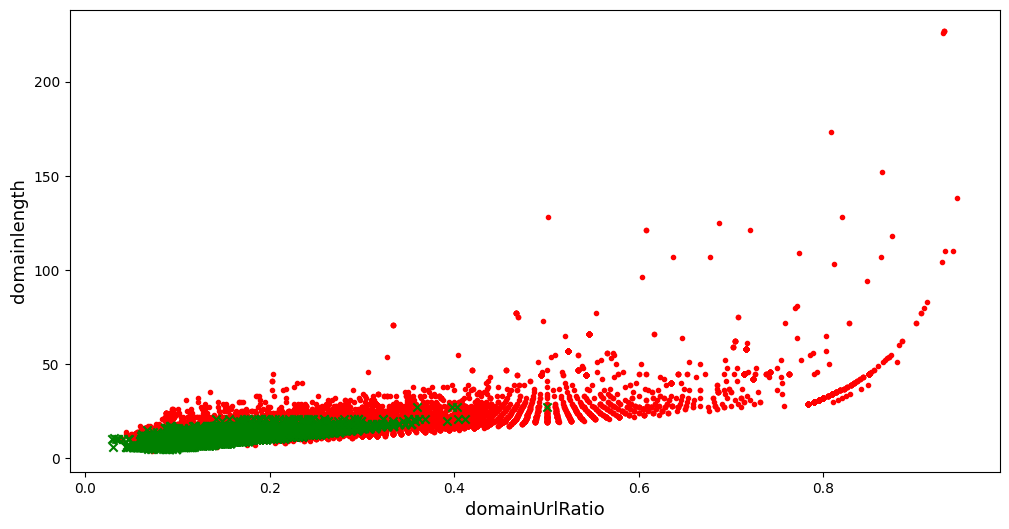

In [12]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "phishing"], df["domainlength"][df['URL_Type_obf_Type'] == "phishing"], c="r", marker=".")
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "benign"], df["domainlength"][df['URL_Type_obf_Type'] == "benign"], c="g", marker="x")
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainlength", fontsize=13)
plt.show()

## 3. División del conjunto de datos

In [13]:
# División del conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [14]:
X_train = train_set.drop("URL_Type_obf_Type", axis=1)
y_train = train_set["URL_Type_obf_Type"].copy()

X_val = val_set.drop("URL_Type_obf_Type", axis=1)
y_val = val_set["URL_Type_obf_Type"].copy()

X_test = test_set.drop("URL_Type_obf_Type", axis=1)
y_test = test_set["URL_Type_obf_Type"].copy()

## 4. Preparación del conjunto de datos

In [15]:
# Eliminamos el atributo que tiene valores infinitos
X_train = X_train.drop("argPathRatio", axis=1)
X_val = X_val.drop("argPathRatio", axis=1)
X_test = X_test.drop("argPathRatio", axis=1)

In [16]:
# Rellenamos los valores nulos con la mediana
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [17]:
# Rellenamos los valores nulos
X_train_prep = imputer.fit_transform(X_train)
X_val_prep = imputer.fit_transform(X_val)
X_test_prep = imputer.fit_transform(X_test)

In [18]:
# Transformamos el resultado a un DataFrame de Pandas
X_train_prep = pd.DataFrame(X_train_prep, columns=X_train.columns, index=y_train.index)
X_val_prep = pd.DataFrame(X_val_prep, columns=X_val.columns, index=y_val.index)
X_test_prep = pd.DataFrame(X_test_prep, columns=X_test.columns, index=y_test.index)

In [19]:
X_train_prep.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
2134,0.0,2.0,6.0,2.000000,2.0,8.666667,2.0,17.0,10.0,0.0,...,2.0,0.0,0.0,-1.0,0.681183,0.827729,0.702637,0.849605,0.000000,-1.000000
9178,0.0,4.0,18.0,3.250000,5.0,1.000000,4.0,18.0,13.0,2.0,...,12.0,3.0,0.0,4.0,0.695232,0.820160,0.682849,0.875578,0.000000,0.778747
13622,0.0,3.0,3.0,6.666666,14.0,4.000000,3.0,1.0,1.0,1.0,...,1.0,0.0,0.0,-1.0,0.836006,0.869991,0.879588,1.000000,0.000000,-1.000000
15182,0.0,3.0,5.0,3.333333,4.0,3.000000,3.0,5.0,2.0,0.0,...,2.0,1.0,0.0,-1.0,0.731804,0.796490,0.796658,1.000000,1.000000,-1.000000
8013,74.0,2.0,13.0,9.500000,17.0,7.875000,2.0,21.0,29.0,26.0,...,4.0,5.0,4.0,3.0,0.653371,0.820569,0.758055,0.714969,0.712215,0.708031
12408,0.0,3.0,4.0,8.333333,19.0,3.750000,3.0,5.0,1.0,0.0,...,2.0,0.0,0.0,-1.0,0.726479,0.789538,0.800705,1.000000,0.000000,-1.000000
509,20.0,2.0,13.0,4.500000,6.0,3.000000,2.0,24.0,17.0,0.0,...,1.0,14.0,13.0,12.0,0.678515,0.796658,0.871049,0.695112,0.701662,0.698106
10714,0.0,3.0,8.0,6.666666,14.0,4.250000,3.0,11.0,5.0,0.0,...,4.0,0.0,0.0,-1.0,0.745348,0.869991,0.788921,1.000000,0.000000,-1.000000
3986,0.0,2.0,6.0,6.500000,10.0,4.500000,2.0,7.0,7.0,0.0,...,2.0,0.0,0.0,-1.0,0.760843,0.798231,0.822491,0.796670,0.000000,-1.000000
748,0.0,2.0,8.0,4.000000,5.0,5.750000,2.0,14.0,14.0,1.0,...,2.0,0.0,0.0,-1.0,0.709062,0.929897,0.884735,0.674994,0.000000,-1.000000


In [20]:
# Comprobamos si hay valores nulos en el conjunto de datos de entrenamiento
is_null = X_train_prep.isna().any()
is_null[is_null]

Series([], dtype: bool)

## 5. SMV: Kernel lineal

### 5.1 Conjunto de datos reducido

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [21]:
# Reducimos el conjunto de datos para representarlo gráficamente
X_train_reduced = X_train_prep[["domainUrlRatio", "domainlength"]].copy()
X_val_reduced = X_val_prep[["domainUrlRatio", "domainlength"]].copy()

In [22]:
X_train_reduced

,domainUrlRatio,domainlength
2134,0.072464,5.0
9178,0.166667,16.0
13622,0.511628,22.0
15182,0.315789,12.0
8013,0.107527,20.0
...,...,...
5191,0.116667,14.0
13418,0.477273,21.0
5390,0.157895,9.0
860,0.072917,7.0


In [23]:
from sklearn.svm import SVC

# SVM Large Margin Classification
svm_clf = SVC(kernel="linear", C=50)
svm_clf.fit(X_train_reduced, y_train)

,C,50
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


**Representación del límite de decisión**

In [24]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

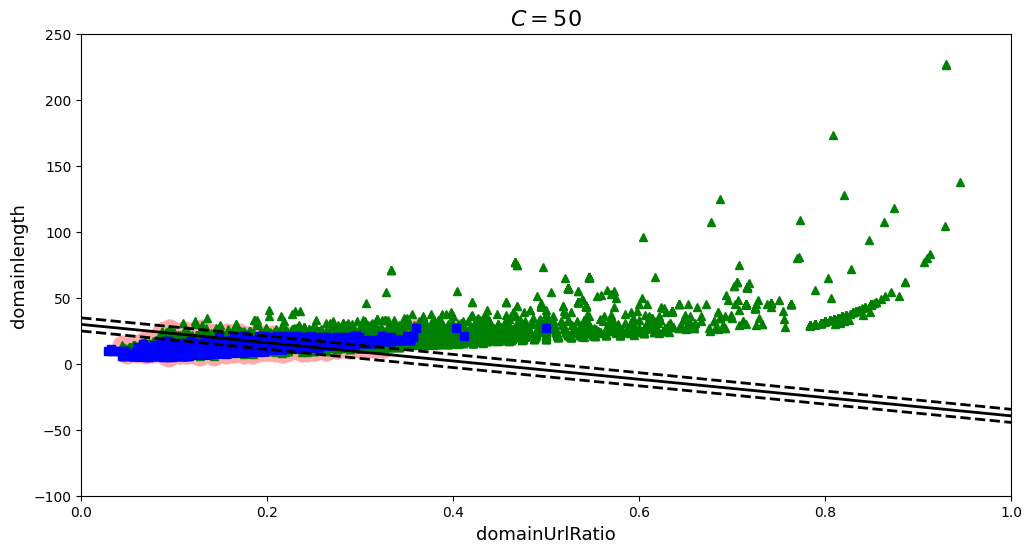

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(X_train_reduced.values[:, 0][y_train=="phishing"], X_train_reduced.values[:, 1][y_train=="phishing"], "g^")
plt.plot(X_train_reduced.values[:, 0][y_train=="benign"], X_train_reduced.values[:, 1][y_train=="benign"], "bs")
plot_svc_decision_boundary(svm_clf, 0, 1)
plt.title("$C = {}$".format(svm_clf.C), fontsize=16)
plt.axis([0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainlength", fontsize=13)
plt.show()

**Predicción con un conjunto de datos reducido**

In [26]:
y_pred = svm_clf.predict(X_val_reduced)

In [27]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='phishing'))

F1 Score: 0.8142614601018676


Como se verá más adelante, para determinados kernels es muy importante escalar el conjunto de datos. En ese caso, para el kernel lineal, no es tan relevante, aunque es posible que proporciones mejores resultados.

In [28]:
svm_clf_sc = Pipeline([
        ("scaler", RobustScaler()),
        ("linear_svc", SVC(kernel="linear", C=50)),
    ])

svm_clf_sc.fit(X_train_reduced, y_train)

,steps,"[('scaler', ...), ('linear_svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True
,unit_variance,False
,C,50
,kernel,'linear'


In [29]:
y_pred = svm_clf_sc.predict(X_val_reduced)

In [30]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='phishing'))

F1 Score: 0.8141592920353983


### 5.2 Conjunto de datos completo

In [31]:
# Entrenamiento con todo el conjunto de datos
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X_train_prep, y_train)

,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [32]:
y_pred = svm_clf.predict(X_val_prep)

In [33]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='phishing'))

F1 Score: 0.961133069828722


## 6. SMV: Kernel no lineal

### 6.1. Polynomial Kernel (I)

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [34]:
# Para representar el límite de decisión tenemos que pasar la variable objetivo a numérica
y_train_num = y_train.factorize()[0]
y_val_num = y_val.factorize()[0]

In [35]:
from sklearn.datasets import make_moons
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=20, loss="hinge", random_state=42, max_iter=100000, dual=True))
    ])

polynomial_svm_clf.fit(X_train_reduced, y_train_num)

,steps,"[('poly_features', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,3
,interaction_only,False
,include_bias,True
,order,'C'
,copy,True
,with_mean,True
,with_std,True


**Representación del límite de decisión**

In [36]:
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g.")
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "b.")

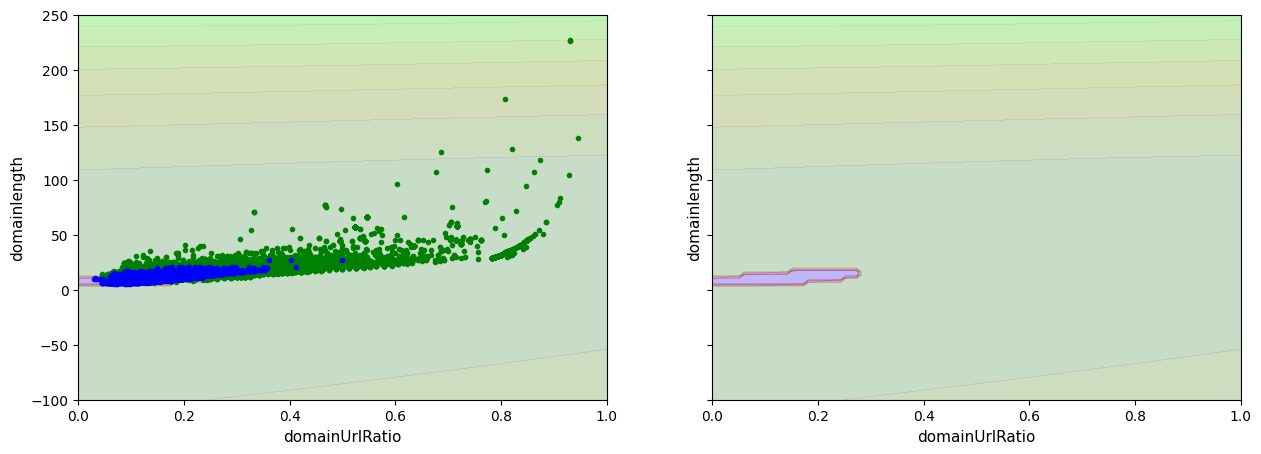

In [37]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Predicción con el conjunto de datos reducido**

In [38]:
y_pred = polynomial_svm_clf.predict(X_val_reduced)

In [39]:
print("F1 Score:", f1_score(y_pred, y_val_num))

F1 Score: 0.857451403887689


### 6.2. Polynomial Kernel (II)

Existe una forma más sencilla de entrenar un algoritmo SVM que utilize polynomial kernel utilizando el parámetro **kernel** de la propia función implementada en sklearn

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [40]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=20)
svm_clf.fit(X_train_reduced, y_train_num)

,C,20
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,10
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


**Representación del límite de decisión**

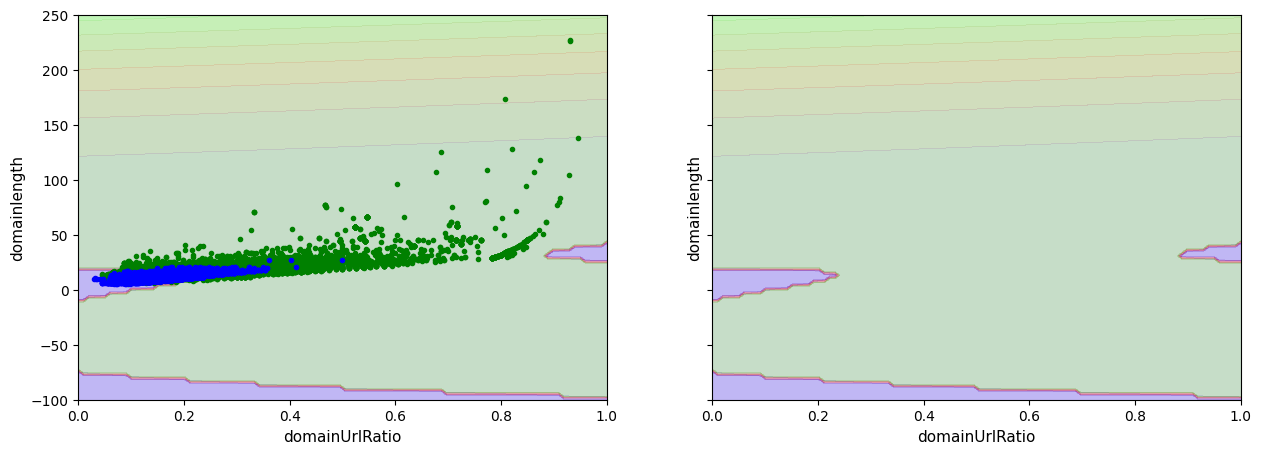

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Predicción con un conjunto de datos reducido**

In [42]:
y_pred = svm_clf.predict(X_val_reduced)

In [43]:
print("F1 Score:", f1_score(y_pred, y_val_num))

F1 Score: 0.8249238062986793


**Predicción con el conjunto de datos completo**

In [44]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=40)
svm_clf.fit(X_train_prep, y_train_num)

,C,40
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,10
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [45]:
y_pred = svm_clf.predict(X_val_prep)

In [46]:
print("F1 Score:", f1_score(y_pred, y_val_num))

F1 Score: 0.9715984147952443


### 6.2. Gaussian Kernel

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [47]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.5, C=1000))
        ])

rbf_kernel_svm_clf.fit(X_train_reduced, y_train_num)

,steps,"[('scaler', ...), ('svm_clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True
,unit_variance,False
,C,1000
,kernel,'rbf'


**Representación del límite de decisión**

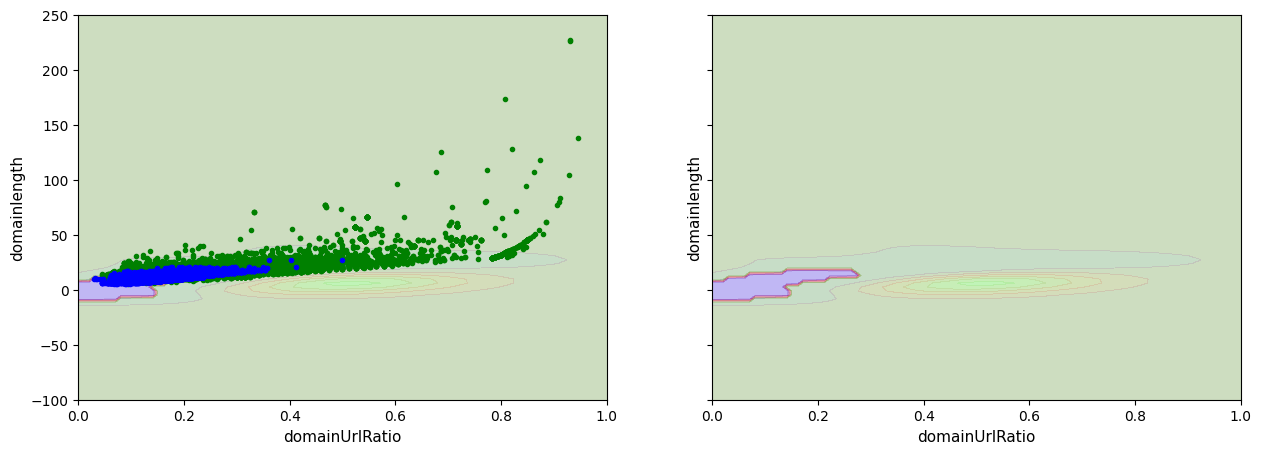

In [48]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(rbf_kernel_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(rbf_kernel_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Predicción con un conjunto de datos reducido**

In [49]:
y_pred = rbf_kernel_svm_clf.predict(X_val_reduced)

In [50]:
print("F1 Score:", f1_score(y_pred, y_val_num))

F1 Score: 0.8617363344051447


**Predicción con un conjunto de datos completo**

In [51]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.05, C=1000))
        ])

rbf_kernel_svm_clf.fit(X_train_prep, y_train_num)

,steps,"[('scaler', ...), ('svm_clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True
,unit_variance,False
,C,1000
,kernel,'rbf'


In [52]:
y_pred = rbf_kernel_svm_clf.predict(X_val_prep)

In [53]:
print("F1 Score:", f1_score(y_pred, y_val_num))

F1 Score: 0.9640522875816994
